<a href="https://colab.research.google.com/github/Alexnder77/DeepLearning--methods-and-applications/blob/main/Lab2_Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5TF078 Deep Learning Course
# Excercise 2 Transfer Learning



## First we initilize our Python environment

In [ ]:
# Import needed libraries
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

import tensorflow.keras
import tensorflow.keras as keras

#import Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist 

print('Keras version:',tensorflow.keras.__version__)

# Helper libraries
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt


TensorFlow version: 2.8.2
Keras version: 2.8.0


In [ ]:
# Test for GPU and determine what GPU we have
import sys
if not tf.config.list_physical_devices('GPU'):
     print("No GPU was detected. CNNs can be very slow without a GPU.")
     IN_COLAB = 'google.colab' in sys.modules
     if IN_COLAB:
         print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
else:
     !nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-7447b670-f4bb-2abd-aefb-8d250df7ee58)


#The Data

### Get hold of a data-set
In this exercise we will use Fashion MNIST dataset, which an alternative to MNIST (it is a little harder, but the image size is the same). This is available directly as a [Keras dataset](https://keras.io/datasets/). This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. 

Note that we split our data into **three** data sets: training, validation, testing; each with its own purpose.

In [ ]:
# Get Fashion-MNIST training and test data from Keras database (https://keras.io/datasets/)
(train_images0, train_labels0), (test_images, test_labels) = tensorflow.keras.datasets.fashion_mnist.load_data()

# Define labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

NEWIMG_WIDTH = 32
NEWIMG_HEIGHT = 32

# Add an "empty" color dimension for our data sets
train_images = np.expand_dims(train_images0, -1)
test_images = np.expand_dims(test_images, -1)

#resizing the images to 32x32x3
train_images = tf.image.grayscale_to_rgb(tf.convert_to_tensor(train_images))
train_images = tf.image.resize_with_pad(train_images, NEWIMG_WIDTH, NEWIMG_HEIGHT, antialias=False)

test_images = tf.image.grayscale_to_rgb(tf.convert_to_tensor(test_images))
test_images = tf.image.resize_with_pad(test_images, NEWIMG_WIDTH, NEWIMG_HEIGHT, antialias=False)


#making sure the dimensions are correct
print('train_images.shape', train_images.shape)
print('test_images.shape', test_images.shape)

# Split the training set into a training and a validation set (20% is validation)
train_images, val_images, train_labels, val_labels = train_test_split(train_images.numpy(), train_labels0, test_size=0.20)

4431872/4422102 [==============================] - 0s 0us/step
train_images.shape (60000, 32, 32, 3)
test_images.shape (10000, 32, 32, 3)


In [ ]:
# Print som basic information of data set sizes and data sizes
train_no,x,y,z = train_images.shape
print('No training images:',train_no, ' with image size:',x,'x',y)
label_no = len(train_labels)
if (label_no != train_no) : 
  print('# labels do not match # training images')

test_no,x,y,z = test_images.shape
label_no = len(test_labels)
print('No test images:',test_no)
if (label_no != test_no) : 
  print('# labels do not match # test images')

val_no,x,y,z = val_images.shape
label_no = len(val_labels)
print('No val images:',val_no)
if (label_no != val_no) : 
  print('# labels do not match # val images')

classes = np.unique(train_labels)
num_classes = len(classes)
print('Training labels:', np.unique(train_labels), "; That is,", num_classes,"classes." )


No training images: 48000  with image size: 32 x 32
No test images: 10000
No val images: 12000
Training labels: [0 1 2 3 4 5 6 7 8 9] ; That is, 10 classes.


Note that the training labels are an integer between 0 and 9, which is not very good as outputs (or inputs) for DL models. A better approach would be to use a one-hot encoding. We can convert our label vectors to one-hot encoded matrices by using [to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) `tensorflow.keras.utils.to_categorical(train_labels)`.

But we can achieve the same thing by using [SparseCategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class) as a loss function instead of the [CategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class). Also note that in both cases we need our model to have as many output nodes as we have classes! 

### Explore the data


Label: Coat


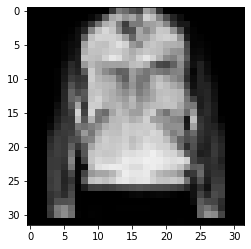

Label: Sandal


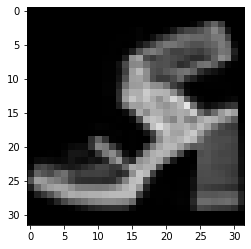

Label: T-shirt/top


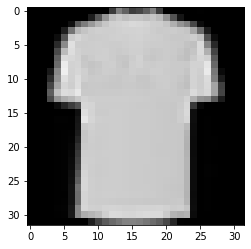

Label: Coat


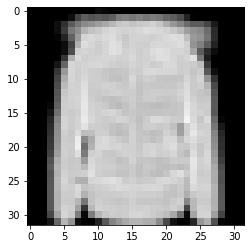

Label: Dress


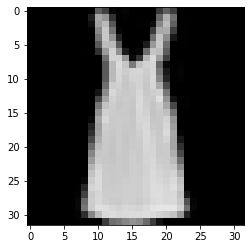

Label: Dress


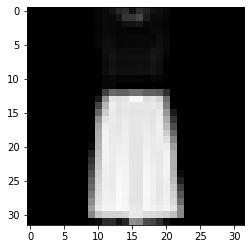

Label: Sandal


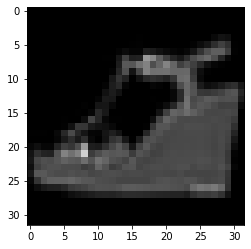

In [ ]:
# As these are images (32x32) it can be interesting to plot some as images
image_index = [13, 89,11,21,45, 2, 1] # "Random" images to print

for index in image_index:
  print( 'Label:', class_names[train_labels[index]])
  plt.figure()
  #plt.imshow(np.squeeze(train_images[index], axis=-1))

  #not sure why using this doesnt work straight away
  #plt.imshow(train_images[index])

  # but found this solution on 
  # https://stackoverflow.com/questions/49643907/clipping-input-data-to-the-valid-range-for-imshow-with-rgb-data-0-1-for-floa
  plt.imshow(np.array(train_images[index],np.int32))

  plt.gray()
  plt.grid(False)
  plt.show(block=False)

# Model 1

In [ ]:
#### Main src https://keras.io/api/applications/#vgg16


# create the base pre-trained model
vgg_model = keras.applications.vgg16.VGG16(
    weights='imagenet', 
    include_top=False,
    input_shape=[NEWIMG_HEIGHT, NEWIMG_HEIGHT, 3]
    )


## adds all the layers untill and including block3_pool to our model
input = vgg_model.get_layer('block3_pool').output

x = keras.layers.BatchNormalization(axis=-1)(input)

# add a global spatial average pooling layer
#x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Flatten()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = Dropout(0.5)(x)

# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = Dropout(0.5)(x)

# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = Dropout(0.5)(x)

# add the output layer
predictions = Dense(units=num_classes, activation='softmax')(x)


# this is the model we will train
model = Model(inputs=vgg_model.input, outputs=predictions)


# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional vgg16 layers

vgg_model.trainable = False

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [ ]:
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy']
)

epochs = 35      ## Number of epoch to run
batch_size = 32  ## Mini batch size

#early stop
es = tf.keras.callbacks.EarlyStopping('val_loss', patience=5, restore_best_weights = True)

# Train the model.
history = model.fit( 
    train_images, to_categorical(train_labels), 
    epochs=epochs, 
    batch_size=batch_size, 
    verbose = 1, 
    callbacks=[es], 
    validation_data=(val_images, to_categorical(val_labels)) 
    )

Epoch 1/35
1500/1500 [==============================] - 25s 8ms/step - loss: 0.5497 - categorical_accuracy: 0.8143 - val_loss: 0.3268 - val_categorical_accuracy: 0.8832
Epoch 2/35
1500/1500 [==============================] - 10s 6ms/step - loss: 0.3598 - categorical_accuracy: 0.8750 - val_loss: 0.2597 - val_categorical_accuracy: 0.9053
Epoch 3/35
1500/1500 [==============================] - 10s 6ms/step - loss: 0.3164 - categorical_accuracy: 0.8893 - val_loss: 0.2471 - val_categorical_accuracy: 0.9082
Epoch 4/35
1500/1500 [==============================] - 11s 7ms/step - loss: 0.2977 - categorical_accuracy: 0.8965 - val_loss: 0.2328 - val_categorical_accuracy: 0.9133
Epoch 5/35
1500/1500 [==============================] - 10s 6ms/step - loss: 0.2800 - categorical_accuracy: 0.9013 - val_loss: 0.2409 - val_categorical_accuracy: 0.9112
Epoch 6/35
1500/1500 [==============================] - 10s 6ms/step - loss: 0.2679 - categorical_accuracy: 0.9066 - val_loss: 0.2316 - val_categorical_acc

# Explore the training progress
Show the training progress, by plotting the training and validation accuracy and loss

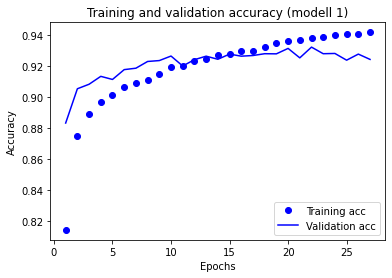

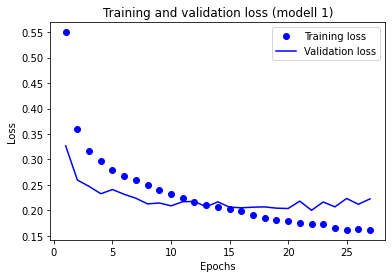

In [ ]:
epochrange = range(1, len(history.history['loss']) + 1)
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochrange, train_acc, 'bo', label='Training acc')
plt.plot(epochrange, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochrange, train_loss, 'bo', label='Training loss')
plt.plot(epochrange, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)

313/313 [==============================] - 2s 6ms/step - loss: 0.2083 - categorical_accuracy: 0.9264
Test accuracy: 0.926


#Model 2

In [ ]:
#### Main src https://keras.io/api/applications/#vgg16


# create the base pre-trained model
vgg_model = keras.applications.vgg16.VGG16(
    weights='imagenet', 
    include_top=False,
    input_shape=[NEWIMG_HEIGHT, NEWIMG_HEIGHT, 3]
    )



## adds all the layers untill and including block3_pool to our model
input = vgg_model.get_layer('block3_pool').output

x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input.shape)

x = keras.layers.BatchNormalization(axis=-1)(input)

x = Flatten()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = Dropout(0.5)(x)

# add the output layer
predictions = Dense(units=num_classes, activation='softmax')(x)


# this is the model we will train
model = Model(inputs=vgg_model.input, outputs=predictions)


# train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional vgg16 layers
vgg_model.trainable = False

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [ ]:
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy']
)

epochs = 35      ## Number of epoch to run
batch_size = 32  ## Mini batch size

#early stop
es = tf.keras.callbacks.EarlyStopping('val_loss', patience=5, restore_best_weights = True)

# Train the model.
history = model.fit( 
    train_images, to_categorical(train_labels), 
    epochs=epochs, 
    batch_size=batch_size, 
    verbose = 1, 
    callbacks=[es], 
    validation_data=(val_images, to_categorical(val_labels)) 
    )

Epoch 1/35
1500/1500 [==============================] - 10s 7ms/step - loss: 0.3982 - categorical_accuracy: 0.8663 - val_loss: 0.2713 - val_categorical_accuracy: 0.9033
Epoch 2/35
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2910 - categorical_accuracy: 0.8961 - val_loss: 0.2707 - val_categorical_accuracy: 0.9032
Epoch 3/35
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2659 - categorical_accuracy: 0.9046 - val_loss: 0.2452 - val_categorical_accuracy: 0.9116
Epoch 4/35
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2493 - categorical_accuracy: 0.9101 - val_loss: 0.2425 - val_categorical_accuracy: 0.9154
Epoch 5/35
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2367 - categorical_accuracy: 0.9139 - val_loss: 0.2515 - val_categorical_accuracy: 0.9108
Epoch 6/35
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2267 - categorical_accuracy: 0.9180 - val_loss: 0.2215 - val_categorical_accuracy

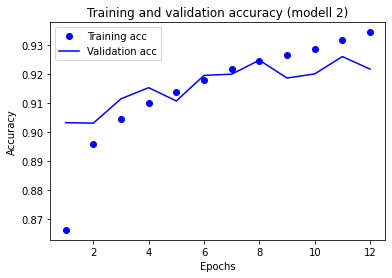

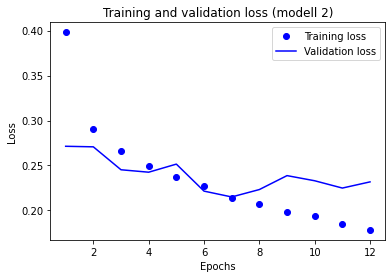

In [ ]:
epochrange = range(1, len(history.history['loss']) + 1)
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochrange, train_acc, 'bo', label='Training acc')
plt.plot(epochrange, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (modell 2)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochrange, train_loss, 'bo', label='Training loss')
plt.plot(epochrange, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (modell 2)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)

313/313 [==============================] - 2s 6ms/step - loss: 0.2309 - categorical_accuracy: 0.9194
Test accuracy: 0.919


model 2 får en test accuracy på 0.919

#Model 3

In [ ]:
# create the base pre-trained model
vgg_model = keras.applications.vgg16.VGG16(
    weights='imagenet', 
    include_top=False,
    input_shape=[NEWIMG_HEIGHT, NEWIMG_HEIGHT, 3]
    )

## adds all the layers untill and including block3_pool to our model
input = vgg_model.get_layer('block3_pool').output

#x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input.shape)

x = keras.layers.BatchNormalization(axis=-1)(input)

# add a global spatial average pooling layer
#x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = Flatten()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = Dropout(0.5)(x)

# add the output layer
predictions = Dense(units=num_classes, activation='softmax')(x)


# this is the model we will train
model = Model(inputs=vgg_model.input, outputs=predictions)


# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional vgg16 layers

vgg_model.trainable = False

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [ ]:
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy']
)

epochs = 35      ## Number of epoch to run
batch_size = 32  ## Mini batch size

#early stop
es = tf.keras.callbacks.EarlyStopping('val_loss', patience=5, restore_best_weights = True)

# Train the model.
history = model.fit( 
    train_images, to_categorical(train_labels), 
    epochs=epochs, 
    batch_size=batch_size, 
    verbose = 1, 
    callbacks=[es], 
    validation_data=(val_images, to_categorical(val_labels)) 
    )

Epoch 1/35
1500/1500 [==============================] - 10s 6ms/step - loss: 0.3955 - categorical_accuracy: 0.8658 - val_loss: 0.2826 - val_categorical_accuracy: 0.8978
Epoch 2/35
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2863 - categorical_accuracy: 0.8967 - val_loss: 0.2818 - val_categorical_accuracy: 0.9004
Epoch 3/35
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2674 - categorical_accuracy: 0.9041 - val_loss: 0.2545 - val_categorical_accuracy: 0.9112
Epoch 4/35
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2503 - categorical_accuracy: 0.9096 - val_loss: 0.2423 - val_categorical_accuracy: 0.9141
Epoch 5/35
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2372 - categorical_accuracy: 0.9148 - val_loss: 0.2623 - val_categorical_accuracy: 0.9105
Epoch 6/35
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2252 - categorical_accuracy: 0.9187 - val_loss: 0.2344 - val_categorical_accuracy

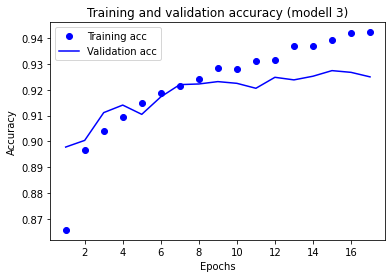

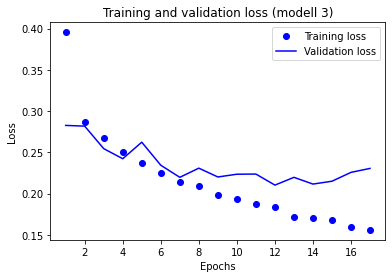

In [ ]:
epochrange = range(1, len(history.history['loss']) + 1)
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochrange, train_acc, 'bo', label='Training acc')
plt.plot(epochrange, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (modell 3)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochrange, train_loss, 'bo', label='Training loss')
plt.plot(epochrange, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (modell 3)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)

313/313 [==============================] - 2s 5ms/step - loss: 0.2199 - categorical_accuracy: 0.9249
Test accuracy: 0.925


Model 3 fick test accuracy på 92.5%

#Analys
Model 1 fick bäst resultat med en test accuaracy på 92.6%

modellen hade 
Total params: 4,037,962
Trainable params: 2,299,914

jämfört med min bästa modell från lab 1 som hade Test accuracy: 0.915 och 1,912,810 parametrar

Det var en väldigt stor skillnad i träningstiden, där min model för förra labben tog mycket (10x) längre tid att träna.  